In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit,execute,Aer
from qiskit.quantum_info.states.random import random_statevector
import numpy as np
import cmath
from math import pi
from random import uniform
from scipy.optimize import minimize
import itertools
from qiskit.aqua.components.optimizers import AQGD

In [2]:
# CZ coupling map
cz_coupling= list(itertools.combinations(range(4), 2))

def layer_block(k):
    layer=QuantumCircuit(4)
    param_idx = 0
    for d in range(k):
        for q_i in range(4):
            layer.rx(p[param_idx],q_i)     
            param_idx+=1
        for q_i in range(4):
            layer.rz(p[param_idx],q_i)
            param_idx+=1
        for cz_index in cz_coupling:
            layer.cz(cz_index[0],cz_index[1])   
        layer.barrier()
    return layer

In [3]:
backend = Aer.get_backend('statevector_simulator') 

def layer_result(circ,angle):
    layer_bind=circ.bind_parameters({p:angle})
    out_state=execute(layer_bind,backend).result().get_statevector()
    return out_state

In [4]:
def state_distance(guess):
    ans_circ=layer_block(num_layers)
    ans=layer_result(ans_circ,guess)
    dif=np.linalg.norm(ans-phi)
    return dif

In [5]:
phi=random_statevector(dims=16).data
print('phi = ',phi)

phi =  [-0.09277405+0.32055939j  0.16264942+0.25857424j -0.10259094-0.12542528j
 -0.08336064+0.2623902j   0.22429436-0.00705334j  0.11522327+0.06798578j
 -0.1213029 +0.23689407j -0.13389589-0.03909304j  0.02520009+0.30415047j
 -0.25713867-0.01311655j  0.03156641+0.1160653j   0.03669233-0.06752242j
  0.15860771+0.34764398j -0.22588653-0.13158001j -0.28488384-0.2346375j
 -0.01262358-0.06471203j]


In [6]:
number_layers=[x for x in range(1,11)]
parameter_set=[]
converge_result=[]
status=[]
optimizer=AQGD(maxiter=1000,eta=1.1)

In [7]:
for i in range(len(number_layers)):
    num_layers=number_layers[i]
    p = ParameterVector('p', 8*num_layers) 
    angle = np.random.uniform(0,2*pi,8*num_layers)
    bnds=[(0,2*pi)]*num_layers*8
    #opt_ans=minimize(state_distance,x0=angle,method='L-BFGS-B',bounds=bnds)
    #converge_result.append(opt_ans.fun)
    #parameter_set.append(opt_ans.x)     
    #status.append(opt_ans.success)
    ans=optimizer.optimize(objective_function=state_distance,initial_point=angle,num_vars=8*num_layers,)
    converge_result.append(ans[1])
    status.append(ans[2])
    parameter_set.append(ans[0])

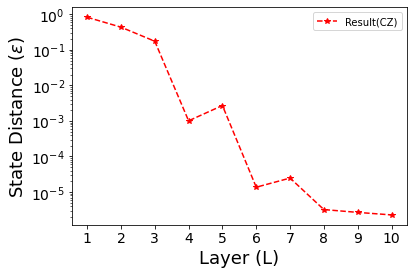

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.figure(figsize=(14,8))
plt.xlabel('Layer (L)',fontsize=18)
plt.ylabel('State Distance ($\epsilon$)',fontsize=18)
plt.plot(number_layers, converge_result,'r*--',label='Result(CZ)')
my_x_ticks = np.arange(1, 11, 1)
plt.xticks(my_x_ticks,fontsize=14)
plt.yscale('log')
#plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.show()